Chess Game Result Analysis - 401 Project

Berkay Yıldız - 201104087 

Zeynep Meriç Aşık - 201410026

# Importing the Dependencies

In [16]:
#!pip install -r requirements.txt

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import seaborn as sns
import plotly.express as px

from random import random
import math
from pyspark import SparkContext
import re
from pyspark.sql import functions as F

In [18]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.conf import SparkConf

from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, when, count, col, isnull, concat_ws, split, desc, sum, mean, abs, std

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, StringIndexer
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

### func's

In [20]:
def string_to_int(col_name, dataset):
    indexer = StringIndexer(inputCol= col_name , outputCol= col_name+"_ind", stringOrderType="frequencyDesc")
    model = indexer.fit(dataset)
    indexed_dataset = model.transform(dataset)
    #cast double to int and change the dataset
    dataset = indexed_dataset.withColumn(col_name+"_ind", col(col_name+"_ind").cast(IntegerType()))
    grouped_data = dataset.groupBy(col_name).agg(count("*").alias("count"))
    return dict(enumerate(model.labels)),grouped_data, dataset

In [21]:
def printMap_and_showTable(_map,_table):
    print(_map)
    _table.show()

In [22]:
def outlier_treatment(dataset, i):
    """function to Remove outliers"""
    sorted_col = dataset.orderBy(dataset.columns[i])
    datacolumn = sorted_col.select(dataset.columns[i])
    percentiles = dataset.approxQuantile(dataset.columns[i], [0.25, 0.75], 0.0)
    Q1, Q3 = percentiles[0], percentiles[1]
    IQR = Q3-Q1
    lower_range = Q1 - (1.5*IQR)
    upper_range = Q3 + (1.5*IQR)
    return lower_range,upper_range,IQR

In [23]:
def count_outliers(dataset, i):
    l, u, IQR = outlier_treatment(dataset, i)
    count = 0
    if IQR != 0:
        count += dataset.filter((col(dataset.columns[i]) > u) | (col(dataset.columns[i]) < l)).count()
    print("lower: ",l,"- upper: ", u)
    print("will be dropped: ",count)
    return count

In [24]:
def drop_outliers(dataset,feature):
    l,u, IQR = outlier_treatment(dataset, dataset.columns.index(feature))
    if IQR!=0:
        dataset = dataset.filter((col(feature) <= u) & (col(feature) >= l))
    return dataset

In [25]:
def map_to_opening_name(index):
    return openName_map.get(index, 'Diğer Açılışlar')

In [26]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
map_to_opening_name_udf = udf(map_to_opening_name, StringType())

### Spark Build

In [27]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [28]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [29]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

### Loading the Data

In [30]:
games = spark.read.format("csv").load("games.csv", header='true', inferSchema='true',  multiline = True)

In [31]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- created_at: double (nullable = true)
 |-- last_move_at: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- increment_code: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [32]:
games = games.withColumnRenamed("created_at", "start_time") \
             .withColumnRenamed("last_move_at", "end_time") \
             .withColumnRenamed("increment_code", "time_increment") 

In [33]:
games.limit(5).toPandas()

id  rated    start_time      end_time  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  time_increment       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_eco  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...         D10   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...         B00   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...         C20   
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...         D02   
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...         C41   

                             opening_name  opening_ply  
0        Slav Defense: Exchange Variation            5  
1  Nimzowitsch Defense: Kennedy Variation            4  
2   King's Pawn Game: Leonardis Variation            3  
3  Queen's Pawn Game: Zukertort Variation            3  
4                        Philidor Defense            5

In [34]:
games.select("rated", "winner", "opening_name","time_increment","white_rating","black_rating").show(5, truncate=False)

+-----+------+--------------------------------------+--------------+------------+------------+
|rated|winner|opening_name                          |time_increment|white_rating|black_rating|
+-----+------+--------------------------------------+--------------+------------+------------+
|false|white |Slav Defense: Exchange Variation      |15+2          |1500        |1191        |
|true |black |Nimzowitsch Defense: Kennedy Variation|5+10          |1322        |1261        |
|true |white |King's Pawn Game: Leonardis Variation |5+10          |1496        |1500        |
|true |white |Queen's Pawn Game: Zukertort Variation|20+0          |1439        |1454        |
|true |white |Philidor Defense                      |30+3          |1523        |1469        |
+-----+------+--------------------------------------+--------------+------------+------------+
only showing top 5 rows



In [35]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- start_time: double (nullable = true)
 |-- end_time: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- time_increment: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [36]:
games.describe().toPandas()

summary        id            start_time               end_time  \
0   count     20058                 20058                  20058   
1    mean      None  1.483616852629092E12  1.4836177223361443E12   
2  stddev      None  2.850150942100429E10   2.850140058889147E10   
3     min  005lW0Xz     1.376771633173E12      1.376771863841E12   
4     max  zzcDhaYF      1.50449314379E12      1.504493827262E12   

               turns victory_status winner time_increment  \
0              20058          20058  20058          20058   
1  60.46599860404826           None   None           None   
2  33.57058475353722           None   None           None   
3                  1           draw  black           0+12   
4                349         resign  white           90+8   

                white_id        white_rating               black_id  \
0                  20058               20058                  20058   
1   2.6775729307708335E9  1596.6318675840064    5.294535237863636E9   
2  1.1283509443243038E10    291.253375737019  1.8875165053331074E10   
3                --jim--                 784                -0olo0-   
4                zzzimon                2700              zztopillo   

         black_rating                                              moves  \
0               20058                                              20058   
1  1588.8319872370128                                               None   
2  291.03612596033423                                               None   
3                 789  Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...   
4                2723  h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...   

  opening_eco                     opening_name         opening_ply  
0       20058                            20058               20058  
1        None                             None  4.8169807558081565  
2        None                             None  2.7971518106301025  
3         A00                 Alekhine Defense                   1  
4         E98  Zukertort Opening: Wade Defense                  28

In [37]:
missing = games.select([count(when(isnull(c), c)).alias(c) for c in games.columns]).show()

+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
| id|rated|start_time|end_time|turns|victory_status|winner|time_increment|white_id|white_rating|black_id|black_rating|moves|opening_eco|opening_name|opening_ply|
+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
|  0|    0|         0|       0|    0|             0|     0|             0|       0|           0|       0|           0|    0|          0|           0|          0|
+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+



No missing (null) values.

# EDA

#### Evaluation by Victory Status

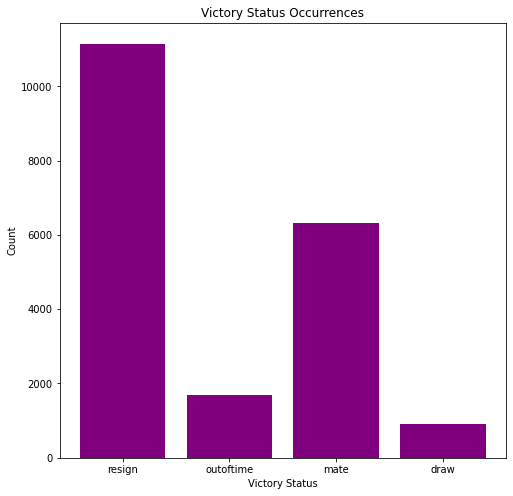

In [38]:
# distribution of the labels
result = games.groupBy("victory_status").count().sort("victory_status", ascending=False)
categories = result.select("victory_status").rdd.flatMap(lambda x: x).collect()
counts = result.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 8))
plt.bar(categories, counts, color='purple')
plt.title('Victory Status Occurrences')
plt.xlabel('Victory Status')
plt.ylabel('Count')
plt.show()

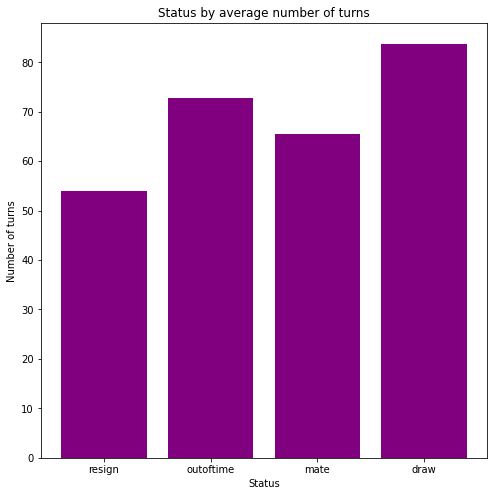

In [39]:
# mean of the labels
turn_df = games.groupBy('victory_status').agg(mean('turns').alias("mean_turns"))
categories = turn_df.select("victory_status").rdd.flatMap(lambda x: x).collect()
mean_turns = turn_df.select("mean_turns").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 8))
plt.bar(categories, mean_turns, color='purple')
plt.title('Status by average number of turns')
plt.xlabel('Status')
plt.ylabel('Number of turns')
plt.show()

##### Evaluation by Winner

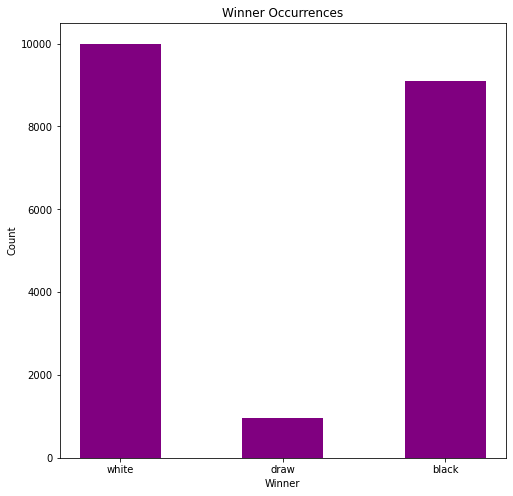

In [40]:
# distribution of the labels
result = games.groupBy("winner").count().sort("winner", ascending=False)
categories = result.select("winner").rdd.flatMap(lambda x: x).collect()
counts = result.select("count").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 8))
plt.bar(categories, counts, color='purple', width=0.5)
plt.title('Winner Occurrences')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

Data is not balanced. The result 'draw' is much less in quantity than the others, should be considered when 'winner' column is used as the target in model training.

In [41]:
# number of wins by all opening_names
grouped_df = games.groupBy('opening_name', 'winner').agg(count('winner').alias('wins'))
open_ = grouped_df.orderBy(desc('wins'))
# number of wins by opening_names by player white and black
black_wins = open_[open_['winner'] == 'black']
white_wins = open_[open_['winner'] == 'white']

Text(0, 0.5, 'Number of Wins')

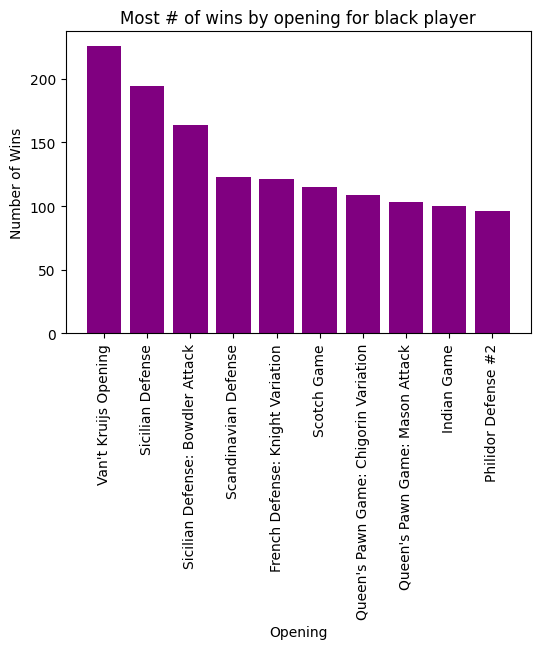

In [42]:
b = black_wins.limit(10)
x = b.select("opening_name").rdd.flatMap(lambda row: row).collect()
y = b.select("wins").rdd.flatMap(lambda row: row).collect()
plt.figure(dpi=100)
plt.bar(x, height=y, color="purple")
plt.xticks(rotation='vertical')
plt.title('Most # of wins by opening for black player')
plt.xlabel('Opening')
plt.ylabel('Number of Wins')

Text(0, 0.5, 'Number of Wins')

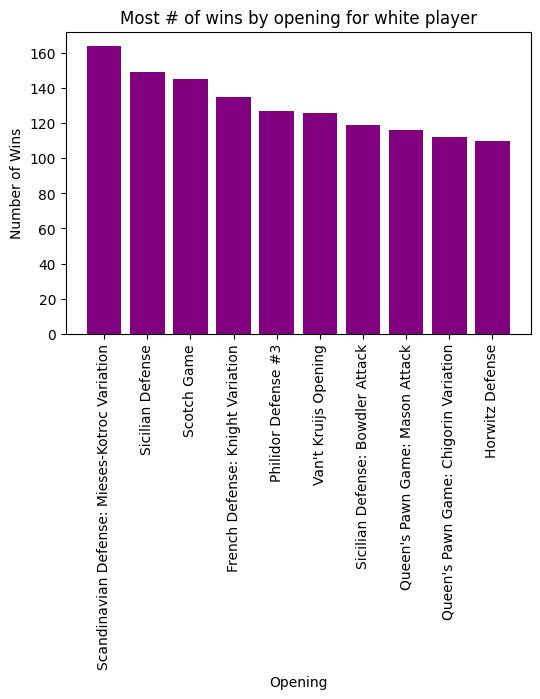

In [43]:
w = white_wins.limit(10)
x = w.select("opening_name").rdd.flatMap(lambda row: row).collect()
y = w.select("wins").rdd.flatMap(lambda row: row).collect()
plt.figure(dpi=100)
plt.bar(x, height=y, color='purple')
plt.xticks(rotation='vertical')
plt.title('Most # of wins by opening for white player')
plt.xlabel('Opening')
plt.ylabel('Number of Wins')

These are the top 10 openings which have the most wins for black and white player. However we can not say that those openings are best for player. Because maybe the situation have worse for it. For instance: Scandinavian opening has 160 win with white player and maybe the opening has 200 lose with it. For this, we will deeply analyse the situations after.

In [44]:
# for each game, it takes the difference between the winner and the loser players' ratings
# if the diff > 0 white's rating is bigger than black 
#             < 0 black's rating is bigger than white

difference = games.withColumn("Difference", (col("white_rating") - col("black_rating")))
difference.select("Winner","Difference").show()

+------+----------+
|Winner|Difference|
+------+----------+
| white|       309|
| black|        61|
| white|        -4|
| white|       -15|
| white|        54|
|  draw|       248|
| white|        97|
| black|      -695|
| black|        47|
| white|       172|
| white|       109|
| black|      -486|
| black|      -555|
| black|      -226|
| white|       -47|
| black|        47|
| black|       -47|
| black|        47|
| black|      -206|
| white|       406|
+------+----------+
only showing top 20 rows



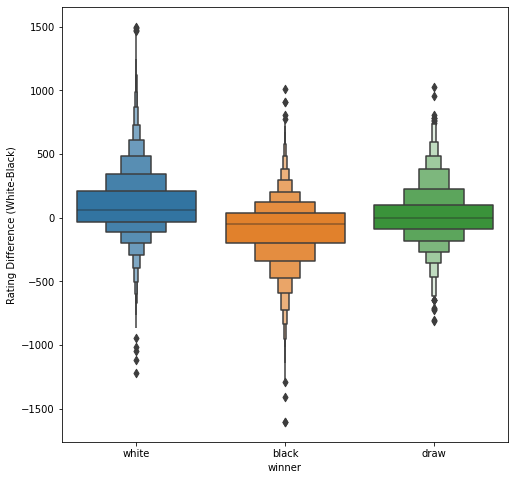

In [45]:
games = games.withColumn('Difference', col('white_rating') - col('black_rating'))

plt.figure(figsize=(8, 8))
sns.boxenplot(x='winner', y='Difference', data=games.toPandas())
plt.ylabel("Rating Difference (White-Black)")
plt.show()

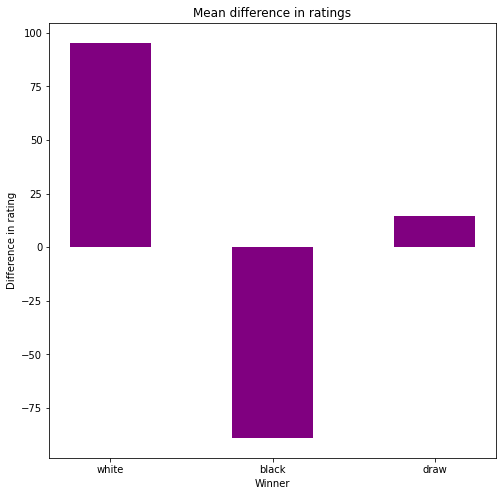

In [46]:
mean_df = difference.groupBy('winner').agg(mean('Difference').alias('Difference'))
x = mean_df.select("winner").rdd.flatMap(lambda row: row).collect()
y = mean_df.select("Difference").rdd.flatMap(lambda row: row).collect()

plt.figure(figsize=(8, 8))
plt.bar(x, height=y, color='purple', width=0.5)
plt.title('Mean difference in ratings')
plt.xlabel('Winner')
plt.ylabel('Difference in rating')
plt.show()

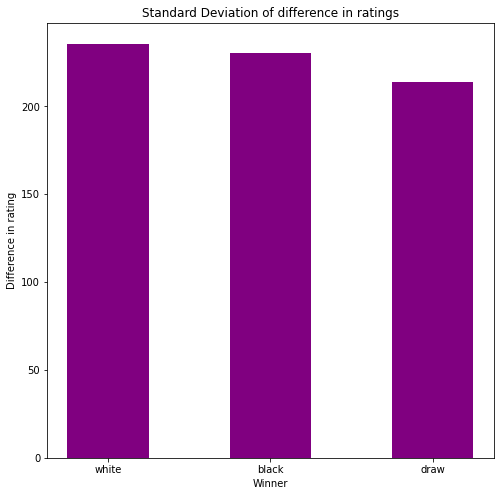

In [47]:
std_df = difference.groupBy('winner').agg(std('Difference').alias('Difference'))
x = std_df.select("winner").rdd.flatMap(lambda row: row).collect()
y = std_df.select("Difference").rdd.flatMap(lambda row: row).collect()

plt.figure(figsize=(8, 8))
plt.bar(x, height=y, color='purple', width=0.5)
plt.title('Standard Deviation of difference in ratings')
plt.xlabel('Winner')
plt.ylabel('Difference in rating')
plt.show()

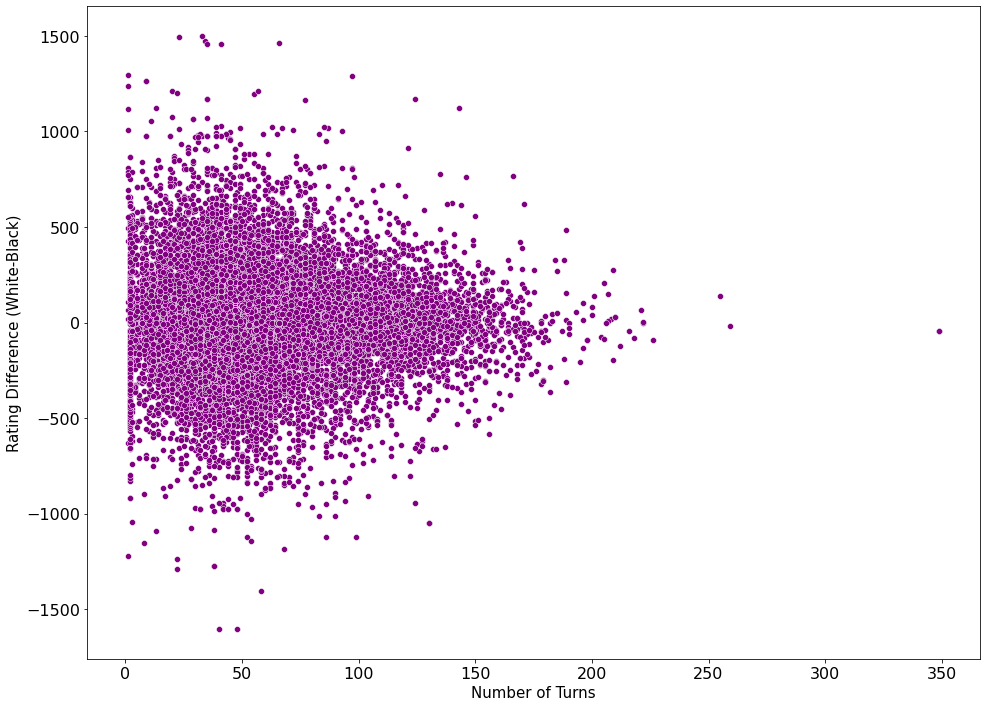

In [48]:
games = games.withColumn("turns", col("turns"))

# Collect data to the driver
data = games.select("turns", "Difference").collect()

# Extract data to Python lists
turns = [row["turns"] for row in data]
difference = [row["Difference"] for row in data]

# Plotting
plt.figure(figsize=(16, 12))
sns.scatterplot(x=turns, y=difference, color='purple')
plt.xticks(fontsize=16)
plt.xlabel("Number of Turns", fontsize=15)
plt.ylabel("Rating Difference (White-Black)", fontsize=15)
plt.yticks(fontsize=16)
plt.show()

## Preprocessing and Analyzing the Data

In [49]:
#controlling duplicated values
window_spec = Window.partitionBy("id")
games_with_count = games.withColumn("count", count("id").over(window_spec))
duplicate_rows = games_with_count.filter("count > 1")
duplicate_rows = duplicate_rows.orderBy("id")
#to see duplicated values
# duplicate_rows.toPandas()
sum_of_duplicated_values = duplicate_rows.select(sum("count")).collect()[0][0]
print("Sum of all duplicated values:", sum_of_duplicated_values)

Sum of all duplicated values: 3968


In [50]:
games = games.dropDuplicates(subset=["id"])

In [51]:
games.describe().toPandas()

summary        id             start_time               end_time  \
0   count     19113                  19113                  19113   
1    mean      None  1.4834131013193103E12  1.4834139747733328E12   
2  stddev      None  2.8339750964260284E10  2.8339639419694557E10   
3     min  005lW0Xz      1.376771633173E12      1.376771863841E12   
4     max  zzcDhaYF       1.50449314379E12      1.504493827262E12   

                turns victory_status winner time_increment  \
0               19113          19113  19113          19113   
1  60.513838748495786           None   None           None   
2   33.48826396268023           None   None           None   
3                   1           draw  black           0+12   
4                 349         resign  white           90+8   

                white_id        white_rating               black_id  \
0                  19113               19113                  19113   
1     2.73448511712766E9   1597.300005232041    6.019286096111111E9   
2  1.1398530926117226E10  290.02273981026565  2.0835821566559532E10   
3                --jim--                 784                -0olo0-   
4                zzzimon                2700              zztopillo   

         black_rating                                              moves  \
0               19113                                              19113   
1   1590.045518756867                                               None   
2  290.44169449070733                                               None   
3                 789  Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...   
4                2723  h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...   

  opening_eco                     opening_name        opening_ply  \
0       19113                            19113              19113   
1        None                             None  4.815779835713912   
2        None                             None  2.798282908005011   
3         A00                 Alekhine Defense                  1   
4         E98  Zukertort Opening: Wade Defense                 28   

           Difference  
0               19113  
1   7.254486475173965  
2  247.44118456060025  
3               -1605  
4                1499

In [52]:
dataset = games.select("*")

#### Rate values to INT

In [53]:
#converting to str
dataset = dataset.withColumn("rated", when(col("rated").cast("string") == "true", "true").otherwise("false"))

In [54]:
rate_map,rate_table,dataset = string_to_int("rated",dataset)

{0: 'true', 1: 'false'}
+-----+-----+
|rated|count|
+-----+-----+
|false| 3646|
| true|15467|
+-----+-----+



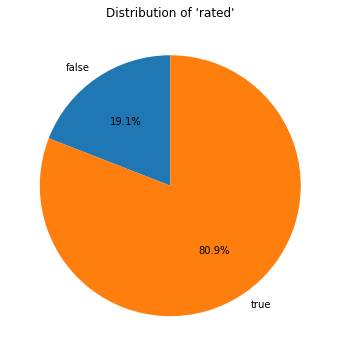

In [55]:
printMap_and_showTable(rate_map,rate_table)

grouped_data = dataset.groupBy("rated").count()
labels = grouped_data.select("rated").rdd.flatMap(lambda row: row).collect()
counts = grouped_data.select("count").rdd.flatMap(lambda row: row).collect()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of 'rated'")
plt.show()

#### Victory values to INT

In [56]:
vic_map,vic_table,dataset = string_to_int("victory_status",dataset)

{0: 'resign', 1: 'mate', 2: 'outoftime', 3: 'draw'}
+--------------+-----+
|victory_status|count|
+--------------+-----+
|        resign|10695|
|     outoftime| 1598|
|          mate| 5974|
|          draw|  846|
+--------------+-----+



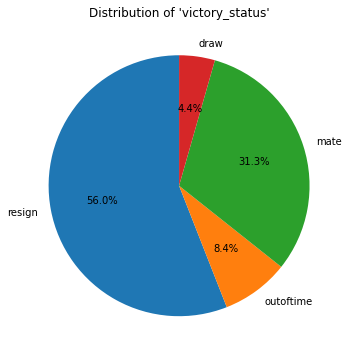

In [57]:
printMap_and_showTable(vic_map,vic_table)

grouped_data = dataset.groupBy("victory_status").count()
labels = grouped_data.select("victory_status").rdd.flatMap(lambda row: row).collect()
counts = grouped_data.select("count").rdd.flatMap(lambda row: row).collect()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of 'victory_status'")
plt.show()

#### Winner values to INT

In [58]:
win_map,win_table,dataset = string_to_int("winner",dataset)

{0: 'white', 1: 'black', 2: 'draw'}
+------+-----+
|winner|count|
+------+-----+
| white| 9545|
| black| 8680|
|  draw|  888|
+------+-----+



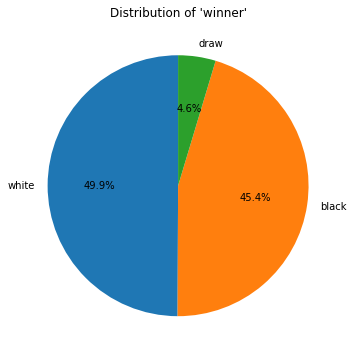

In [59]:
printMap_and_showTable(win_map,win_table)

grouped_data = dataset.groupBy("winner").count()
labels = grouped_data.select("winner").rdd.flatMap(lambda row: row).collect()
counts = grouped_data.select("count").rdd.flatMap(lambda row: row).collect()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of 'winner'")
plt.show()

White appears to win 49.9 % of the games  
while Black wins 45.4 % of the games  
and 4.6 % of the games are a draw after cleaning the data.  
This means that our data is unbalanced for draw, so it will be harder for the model to learn 'draw' values.

#### Opening Name values to INT

In [60]:
openName_map,openName_table,dataset = string_to_int("opening_name",dataset)

In [61]:
printMap_and_showTable(openName_map,openName_table)

{0: 'Sicilian Defense', 1: "Van't Kruijs Opening", 2: 'Sicilian Defense: Bowdler Attack', 3: 'French Defense: Knight Variation', 4: 'Scotch Game', 5: 'Scandinavian Defense: Mieses-Kotroc Variation', 6: "Queen's Pawn Game: Mason Attack", 7: "Queen's Pawn Game: Chigorin Variation", 8: 'Scandinavian Defense', 9: 'Horwitz Defense', 10: 'Caro-Kann Defense', 11: 'Philidor Defense #3', 12: 'Philidor Defense #2', 13: 'Indian Game', 14: 'Modern Defense', 15: 'Italian Game: Anti-Fried Liver Defense', 16: "King's Pawn Game: Wayward Queen Attack", 17: 'Four Knights Game: Italian Variation', 18: 'Owen Defense', 19: 'Sicilian Defense: Old Sicilian', 20: "King's Pawn Game: Leonardis Variation", 21: "Queen's Pawn Game", 22: 'Philidor Defense', 23: 'Ruy Lopez: Steinitz Defense', 24: "Queen's Pawn", 25: "Queen's Gambit Refused: Marshall Defense", 26: "Bishop's Opening", 27: 'French Defense: Normal Variation', 28: 'Hungarian Opening', 29: "Queen's Gambit Declined", 30: "Queen's Pawn Game: Zukertort Varia

+--------------------+-----+
|        opening_name|count|
+--------------------+-----+
|Alekhine Defense:...|    3|
|King's Indian Att...|    4|
|Sicilian Defense:...|    2|
|Caro-Kann Defense...|    1|
|Owen Defense: Smi...|    2|
|Sicilian Defense:...|   48|
|Sicilian Defense:...|    1|
|Queen's Gambit Ac...|   11|
|French Defense: C...|    8|
|French Defense: S...|   10|
|French Defense: W...|    1|
|King's Pawn Game:...|   78|
|  St. George Defense|   43|
|Nimzowitsch Defen...|   24|
|Pirc Defense: Aus...|    6|
|Scotch Game: Mala...|    6|
|Ruy Lopez: Berlin...|    5|
|Nimzo-Larsen Atta...|    6|
|French Defense: F...|    1|
|Sicilian Defense:...|    1|
+--------------------+-----+
only showing top 20 rows



#### Opening eco values to INT

In [62]:
openEco_map,openEco_table,dataset = string_to_int("opening_eco",dataset)

In [63]:
printMap_and_showTable(openEco_map,openEco_table)

{0: 'A00', 1: 'C00', 2: 'D00', 3: 'B01', 4: 'C41', 5: 'C20', 6: 'A40', 7: 'B00', 8: 'B20', 9: 'C50', 10: 'C40', 11: 'D02', 12: 'C44', 13: 'C42', 14: 'B07', 15: 'C55', 16: 'C45', 17: 'C02', 18: 'A04', 19: 'C46', 20: 'A45', 21: 'B21', 22: 'B50', 23: 'B30', 24: 'D20', 25: 'B10', 26: 'B06', 27: 'C21', 28: 'D06', 29: 'A01', 30: 'B12', 31: 'C01', 32: 'B02', 33: 'C23', 34: 'D30', 35: 'C62', 36: 'A10', 37: 'B40', 38: 'B32', 39: 'C57', 40: 'A06', 41: 'C24', 42: 'D10', 43: 'C65', 44: 'B23', 45: 'C60', 46: 'B90', 47: 'A20', 48: 'B22', 49: 'C68', 50: 'C30', 51: 'D01', 52: 'C53', 53: 'B13', 54: 'A46', 55: 'C48', 56: 'E20', 57: 'A03', 58: 'A43', 59: 'D31', 60: 'A02', 61: 'B54', 62: 'C22', 63: 'A41', 64: 'C34', 65: 'D35', 66: 'C70', 67: 'B27', 68: 'C26', 69: 'A21', 70: 'E61', 71: 'A15', 72: 'C10', 73: 'A22', 74: 'A80', 75: 'C64', 76: 'C47', 77: 'A13', 78: 'B25', 79: 'B33', 80: 'E00', 81: 'D07', 82: 'D15', 83: 'B08', 84: 'C77', 85: 'D04', 86: 'D11', 87: 'C11', 88: 'C54', 89: 'C61', 90: 'A30', 91: 'B34

#### Time Inc values to INT

In [64]:
timeInc_map,timeInc_table,dataset = string_to_int("time_increment",dataset)

In [65]:
printMap_and_showTable(timeInc_map,timeInc_table)

{0: '10+0', 1: '15+0', 2: '15+15', 3: '5+5', 4: '5+8', 5: '8+0', 6: '10+5', 7: '15+10', 8: '20+0', 9: '30+0', 10: '10+10', 11: '15+5', 12: '7+2', 13: '10+2', 14: '30+30', 15: '5+10', 16: '10+3', 17: '25+0', 18: '10+8', 19: '20+10', 20: '15+2', 21: '10+15', 22: '9+0', 23: '45+45', 24: '20+5', 25: '8+8', 26: '180+0', 27: '15+8', 28: '30+10', 29: '10+1', 30: '8+5', 31: '12+0', 32: '20+15', 33: '7+5', 34: '180+180', 35: '60+0', 36: '15+3', 37: '7+7', 38: '7+9', 39: '20+20', 40: '20+3', 41: '6+5', 42: '15+1', 43: '7+3', 44: '8+2', 45: '9+5', 46: '12+10', 47: '11+0', 48: '5+7', 49: '30+5', 50: '5+6', 51: '7+4', 52: '15+14', 53: '7+8', 54: '5+15', 55: '4+6', 56: '7+10', 57: '45+0', 58: '7+15', 59: '9+8', 60: '3+8', 61: '10+4', 62: '2+10', 63: '25+3', 64: '8+10', 65: '10+6', 66: '25+5', 67: '8+3', 68: '25+25', 69: '6+8', 70: '14+0', 71: '20+60', 72: '20+8', 73: '6+4', 74: '6+6', 75: '10+30', 76: '16+0', 77: '20+30', 78: '12+5', 79: '15+60', 80: '5+60', 81: '6+3', 82: '12+12', 83: '6+10', 84: '

#### Combining or Dropping the Redundant/Non-informing Columns

In [66]:
dataset = dataset.withColumn("game_duration", (col("end_time") - col("start_time")).cast("double"))

In [67]:
columns_to_drop = ["id", "rated", "victory_status", "winner", "start_time", "end_time", "white_id", "black_id", "moves","opening_name","opening_eco","time_increment"]
dataset = dataset.drop(*columns_to_drop)

"id" column is dropped since it does not provide information for analysis.
Our goal is to analyse the moves and its results, not the specific player's chess skills. So, the "white_id" and "black_id" columns are also dropped, but their ratings remain.  
"created_at" and "last_move_at" columns are dropped and the difference was added to new column "game_duration".  
Other columns are dropped because they are stored in one hot form in different columns (_ind).  
Original dataset is stored in "games" dataframe. Preprocessed data ("dataset") will be used from now on to perform analysis and prediction.

In [68]:
dataset.limit(5).toPandas()

turns  white_rating  black_rating  opening_ply  Difference  rated_ind  \
0     37          1500          1479           10          21          1   
1     47          1568          1561            4           7          0   
2     29          1418          1330            4          88          0   
3    138          1537          1500            3          37          1   
4     57          1710          1777            3         -67          0   

   victory_status_ind  winner_ind  opening_name_ind  opening_eco_ind  \
0                   0           0               237              135   
1                   1           0                72               10   
2                   2           0                 5                3   
3                   2           1                 2                8   
4                   0           0                73                8   

   time_increment_ind  game_duration  
0                   6       371839.0  
1                  19       770082.0  
2                   4       843568.0  
3                   1            0.0  
4                  12       285376.0

In [69]:
dataset.describe().toPandas()

summary               turns        white_rating       black_rating  \
0   count               19113               19113              19113   
1    mean  60.513838748495786   1597.300005232041  1590.045518756867   
2  stddev  33.488263962680236  290.02273981026576  290.4416944907076   
3     min                   1                 784                789   
4     max                 349                2700               2723   

         opening_ply          Difference            rated_ind  \
0              19113               19113                19113   
1  4.815779835713912   7.254486475173965  0.19076021556008999   
2  2.798282908005004  247.44118456060048  0.39291071871790373   
3                  1               -1605                    0   
4                 28                1499                    1   

   victory_status_ind          winner_ind    opening_name_ind  \
0               19113               19113               19113   
1  0.6125673625281223  0.5470622089677183  203.51530371998118   
2  0.8186318372429175  0.5837157046103743  275.13278842195825   
3                   0                   0                   0   
4                   3                   2                1476   

     opening_eco_ind  time_increment_ind      game_duration  
0              19113               19113              19113  
1  40.22372207398106  20.535656359545857  873454.0226547376  
2  54.36814715524886   47.70505405518881    4927360.5034804  
3                  0                   0                0.0  
4                364                 399       6.05844701E8

In [70]:
"""
Checked outlier values but not dropped all because:
    -some columns are changed and they might be misunderstood by function
        for ex: victory_status_ind has "resign,outoftime,mate,draw" if there are so many resign   draw(3) matches could be dropped.
    -want to check manually if there are too many values to be dropped
    -want to control before deletion
"""
for i, column in enumerate(dataset.columns , start=0):
    print(column)
    count_outliers(dataset, i)
    print("")

turns
lower:  -26.0 - upper:  142.0
will be dropped:  412

white_rating
lower:  814.5 - upper:  2378.5
will be dropped:  130

black_rating
lower:  807.5 - upper:  2371.5
will be dropped:  92

opening_ply
lower:  -1.5 - upper:  10.5
will be dropped:  859

Difference
lower:  -453.0 - upper:  467.0
will be dropped:  1443

rated_ind
lower:  0.0 - upper:  0.0
will be dropped:  0

victory_status_ind
lower:  -1.5 - upper:  2.5
will be dropped:  846

winner_ind
lower:  -1.5 - upper:  2.5
will be dropped:  0

opening_name_ind
lower:  -344.5 - upper:  635.5
will be dropped:  1620

opening_eco_ind
lower:  -63.0 - upper:  121.0
will be dropped:  1646

time_increment_ind
lower:  -22.5 - upper:  37.5
will be dropped:  2824

game_duration
lower:  -1171578.0 - upper:  1952630.0
will be dropped:  1386



turns, white&black_rating, opening_play, game_duration will be dropped 

In [71]:
dataset = drop_outliers(dataset,"turns")
dataset = drop_outliers(dataset,"white_rating")
dataset = drop_outliers(dataset,"black_rating")
dataset = drop_outliers(dataset,"opening_ply")
dataset = drop_outliers(dataset,"game_duration")

In [72]:
dataset.describe().toPandas()

summary               turns       white_rating        black_rating  \
0   count               16482              16482               16482   
1    mean   56.85972576143672  1575.547020992598  1569.3219269506128   
2  stddev  29.812208475082645  275.6521723874218  278.65315596153295   
3     min                   1                826                 818   
4     max                 142               2367                2358   

         opening_ply          Difference            rated_ind  \
0              16482               16482                16482   
1  4.422885572139304   6.225094041985196  0.18492901346923918   
2  2.211367331384638  240.00768763109554  0.38825174712553784   
3                  1               -1273                    0   
4                 10                1290                    1   

   victory_status_ind          winner_ind    opening_name_ind  \
0               16482               16482               16482   
1  0.5848198034219149  0.5350685596408203  178.88526877806092   
2  0.7895440237734541  0.5718891850746219  244.87016059334704   
3                   0                   0                   0   
4                   3                   2                1475   

      opening_eco_ind  time_increment_ind       game_duration  
0               16482               16482               16482  
1   34.32981434291955  19.774602596772237  337885.80669821624  
2  45.270104788383655   47.04563883383448   436799.1557864082  
3                   0                   0                 0.0  
4                 363                 399           1847296.0

### Correlation Matrix

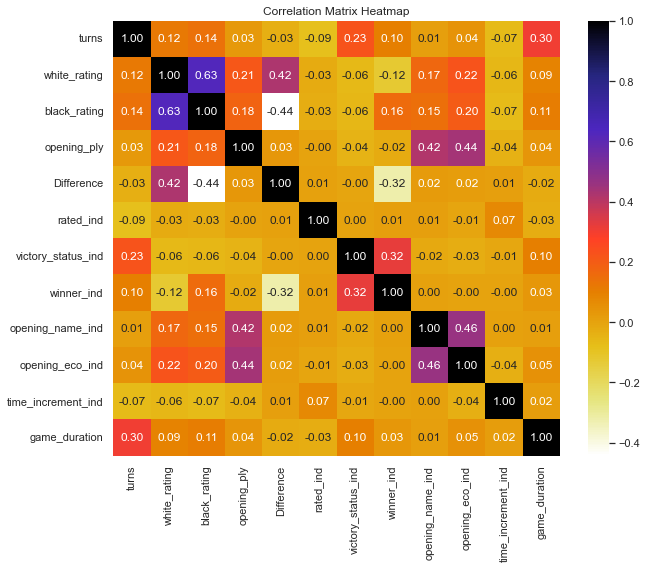

In [73]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=dataset.columns, outputCol="features")
assembled_df = assembler.transform(dataset)

correlation_matrix = Correlation.corr(assembled_df, "features", "pearson")

correlation_matrix_pd = correlation_matrix.select("pearson(features)").collect()[0][0]
correlation_matrix_np = np.array(correlation_matrix_pd.toArray())

sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_np, annot=True, fmt=".2f", cmap=plt.cm.CMRmap_r, xticklabels=dataset.columns, yticklabels=dataset.columns)
plt.title("Correlation Matrix Heatmap")
plt.show()

As it can be seen from the map, victory_status has the highest correlation (0.32) with winner_ind (target data) which we are trying to make predictions on. The reason behind this is that victory status and winner both contain the label 'draw'. As we want to avoid overfitting or data leakage, victory_status cannot be used in model training nor prediction. Hence, it will be dropped after data analysis before ML model training.

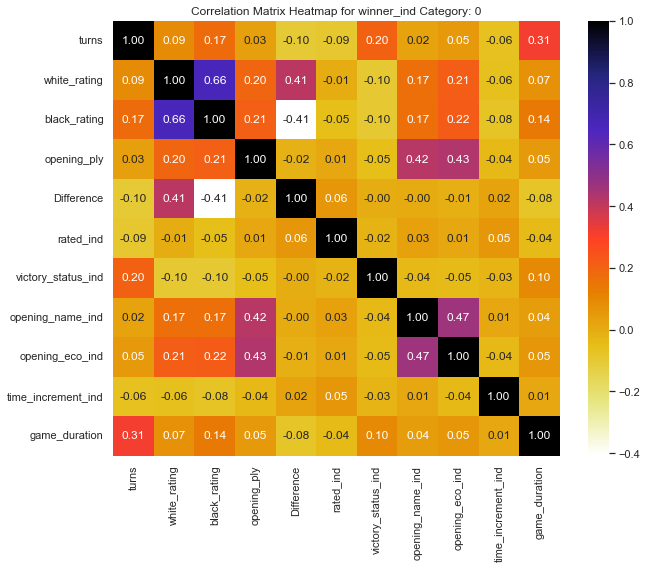

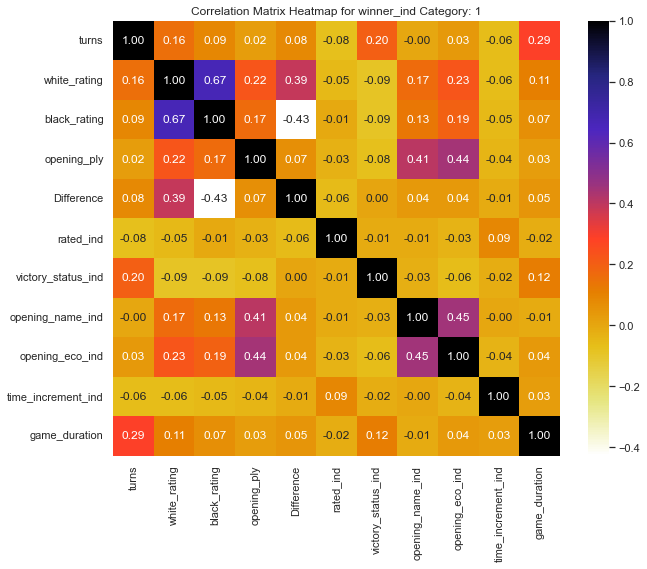

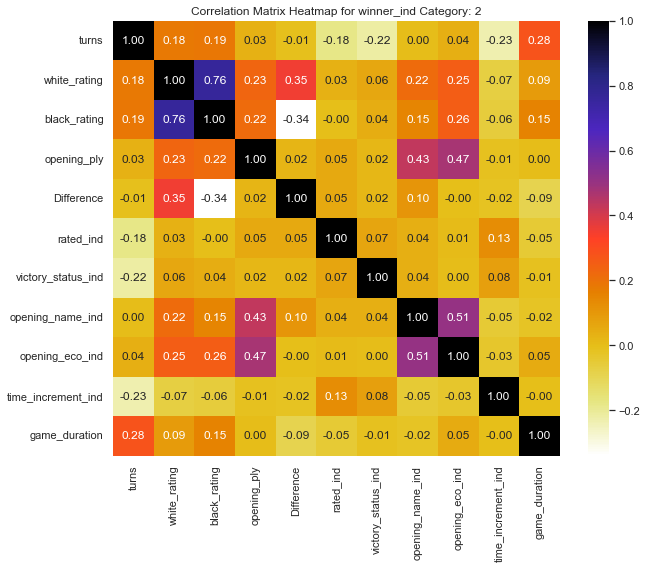

In [74]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

victory_categories = [0, 1, 2]  # white, black, draw

for category in victory_categories:
    filtered_dataset = dataset.filter(dataset['winner_ind'] == category)
    
    assembler = VectorAssembler(inputCols=[col for col in filtered_dataset.columns if col != 'winner_ind'],
                                outputCol="features")
    assembled_df = assembler.transform(filtered_dataset)
    
    correlation_matrix = Correlation.corr(assembled_df, "features", "pearson")
    correlation_matrix_pd = correlation_matrix.select("pearson(features)").collect()[0][0]
    correlation_matrix_np = np.array(correlation_matrix_pd.toArray())
    
    sns.set(style="white")
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_np, annot=True, fmt=".2f", cmap=plt.cm.CMRmap_r,
                xticklabels=[col for col in filtered_dataset.columns if col != 'winner_ind'],
                yticklabels=[col for col in filtered_dataset.columns if col != 'winner_ind'])
    plt.title(f"Correlation Matrix Heatmap for winner_ind Category: {category}")
    plt.show()

#### How to scale the data?

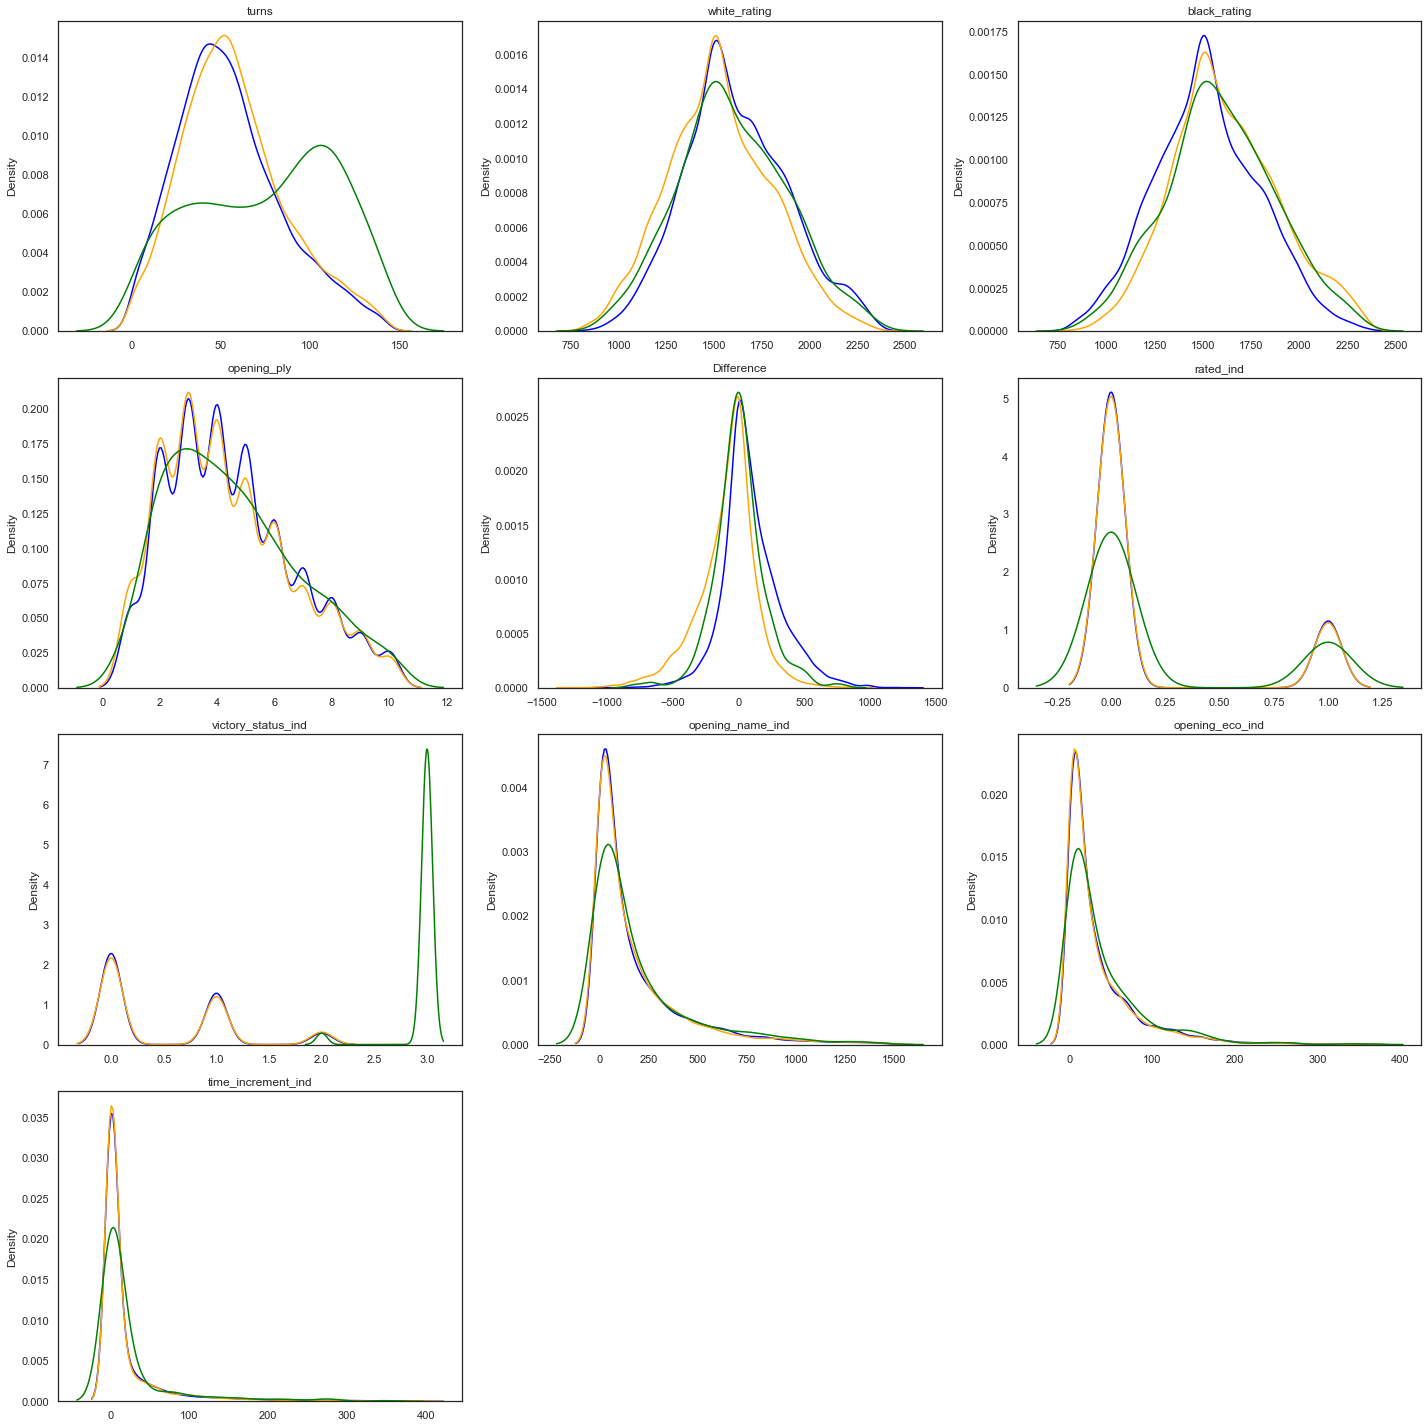

In [75]:
cols = dataset.columns
data_0 = dataset.filter(col("winner_ind") == 0).select(cols).collect()
data_1 = dataset.filter(col("winner_ind") == 1).select(cols).collect()
data_2 = dataset.filter(col("winner_ind") == 2).select(cols).collect()

cols.remove('winner_ind')
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
for feature, axes in zip(cols, ax.ravel()):
    sns.kdeplot([row[feature] for row in data_0], color='blue', ax=axes)   # white
    sns.kdeplot([row[feature] for row in data_1], color='orange', ax=axes) # black
    sns.kdeplot([row[feature] for row in data_2], color='green', ax=axes)  # draw
    axes.set_title(feature)

fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
plt.tight_layout()
plt.show()

From most of the features, it can be said that data is positively skewed and not normally distributed. We might have issues in variability since the spread is not that wide except for a few features. Looks like game_duration will not be providing many information to us since the data there does not look very reliable. Also out target data (winner) is not balanced.  
From these informations, the most appropriate Scaler for this data would be StandardScaler.

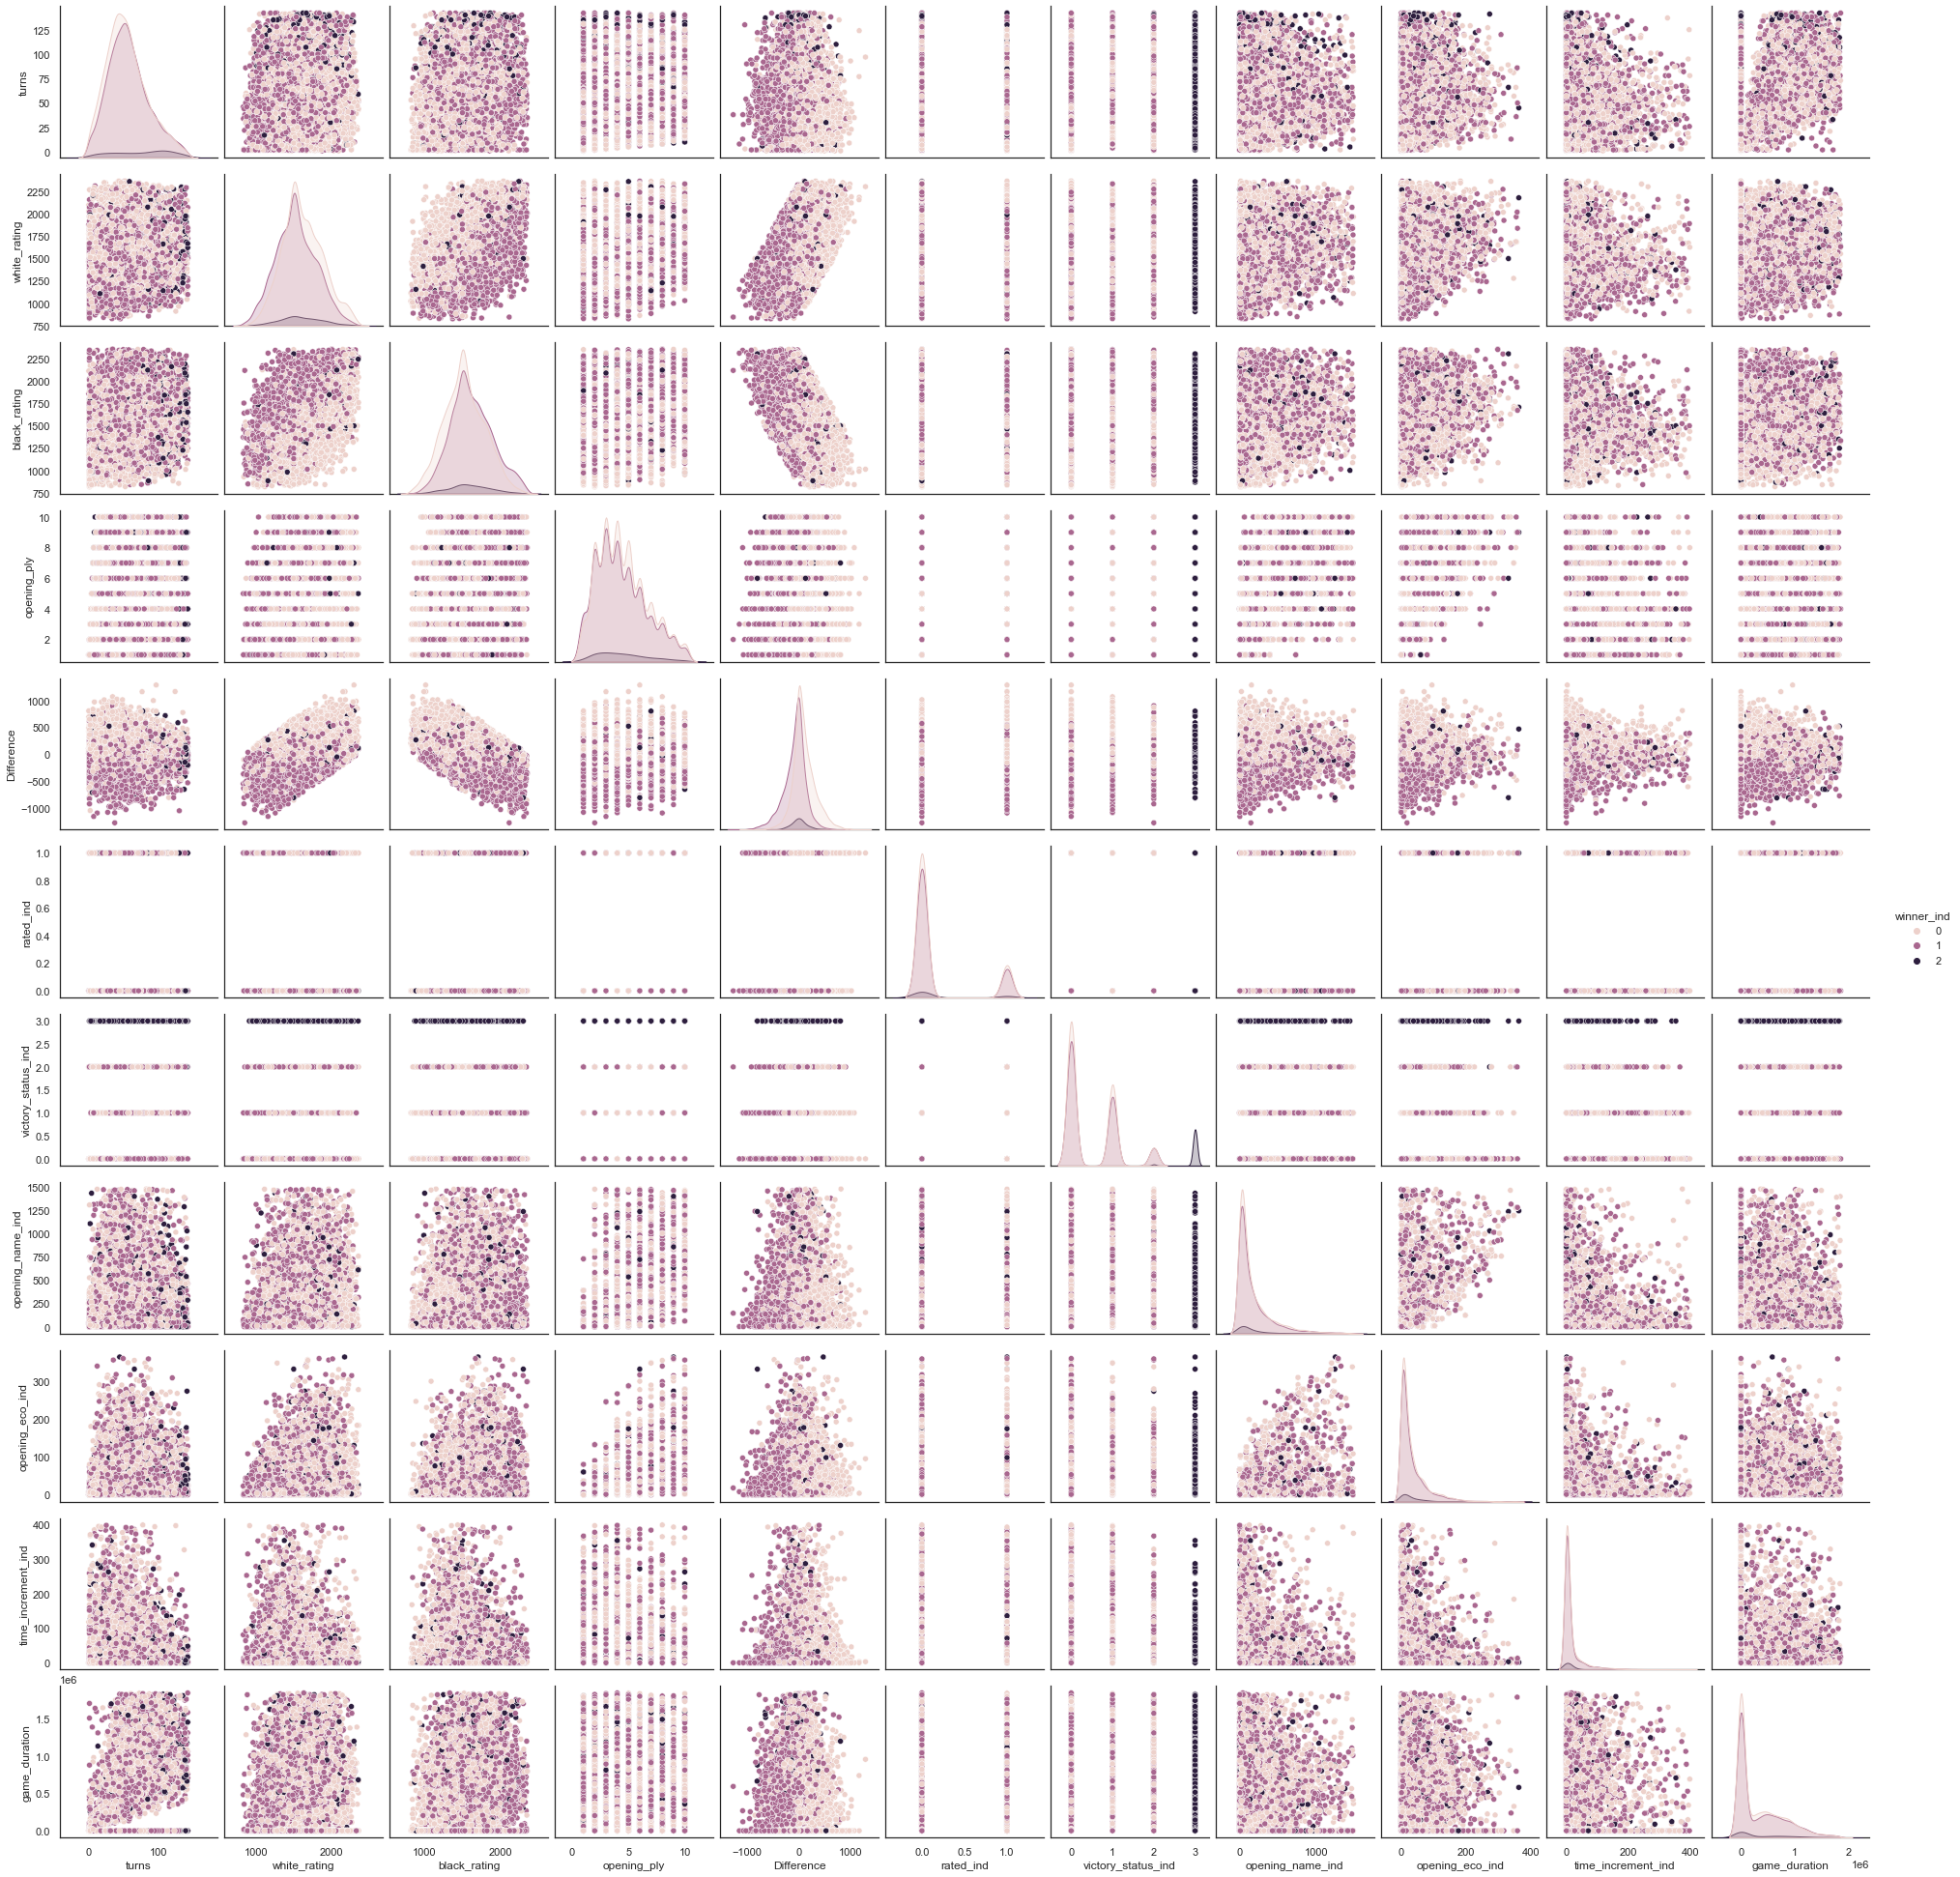

In [76]:
dataa = dataset.toPandas()
sns.pairplot(data=dataa,hue='winner_ind')

This is the visualization of a pair plot. However, probably because our data is unbalanced, this graph does not really provide any new information other than it being unbalanced.

In [77]:
from pyspark.sql.functions import when, col, count, round

# 'winner' sütununu baz alarak 'white_wins_count', 'black_wins_count' ve 'draws_count' sütunlarını oluşturma
dataset = dataset.withColumn('white_wins_count', when(col('victory_status_ind') == 0, 1).otherwise(0)) \
                 .withColumn('black_wins_count', when(col('victory_status_ind') == 1, 1).otherwise(0)) \
                 .withColumn('draws_count', when(col('victory_status_ind') == 2, 1).otherwise(0))

# Açılışlara göre toplam oyun sayısını ve kazanma/kaybetme/beraberlik sayılarını hesaplama
result_df = dataset.groupBy('opening_name_ind') \
                   .agg(count('*').alias('total_count'),
                        count(when(col('victory_status_ind') == 0, True)).alias('white_wins_count'),
                        count(when(col('victory_status_ind') == 1, True)).alias('black_wins_count'),
                        count(when(col('victory_status_ind') == 2, True)).alias('draws_count')) \
                   .fillna(0)

# Kazanma, kaybetme ve berabere kalma oranlarını hesaplama
result_df = result_df.withColumn('white_wins_rate', round((col('white_wins_count') / col('total_count')) * 100, 2)) \
                     .withColumn('black_wins_rate', round((col('black_wins_count') / col('total_count')) * 100, 2)) \
                     .withColumn('draws_rate', round((col('draws_count') / col('total_count')) * 100, 2)) \
                     .orderBy(col('white_wins_rate').desc(), col('total_count').desc())

# En yüksek kazanma oranlarına sahip 5 açılışı bulma
top_5_white_wins = result_df.limit(5).select(map_to_opening_name_udf('opening_name_ind').alias('opening_name'),'total_count','white_wins_rate')

# En yüksek kaybetme oranlarına sahip 5 açılışı bulma
top_5_black_wins = result_df.select(map_to_opening_name_udf('opening_name_ind').alias('opening_name'),'total_count','black_wins_rate').orderBy(col('black_wins_rate').desc(), col('total_count').desc()).limit(5)

# En fazla beraberlik oranına sahip 5 açılışı bulma
top_5_draws = result_df.select(map_to_opening_name_udf('opening_name_ind').alias('opening_name'),'total_count','draws_rate').orderBy(col('draws_rate').desc(), col('total_count').desc()).limit(5)

# Sonuçları yazdırma
print("Openings with the Highest White Player Winning Rate:")
top_5_white_wins.show(truncate=False)

print("\nOpenings with the Highest Black Player Winning Rate:")
top_5_black_wins.show(truncate=False)

print("\nOpenings with the Highest Draw Ending Rate:")
top_5_draws.show(truncate=False)


Openings with the Highest White Player Winning Rate:
+--------------------------------------------------------+-----------+---------------+
|opening_name                                            |total_count|white_wins_rate|
+--------------------------------------------------------+-----------+---------------+
|Scotch Game: Classical Variation |  Intermezzo Variation|14         |100.0          |
|Tarrasch Defense: Symmetrical Variation                 |9          |100.0          |
|Scotch Game: Haxo Gambit                                |9          |100.0          |
|Queen's Gambit Declined: Harrwitz Attack                |9          |100.0          |
|Dutch Defense: Normal Variation                         |9          |100.0          |
+--------------------------------------------------------+-----------+---------------+


Openings with the Highest Black Player Winning Rate:
+---------------------------------------------------------------------+-----------+---------------+
|opening_

We see the winning rates in the table above, but since these are not openings that are played very often, weighted scoring is used to calculate which game opening will get the higher score for white, black or draw.

In [78]:
# Açılış indeksini açılış adına dönüştüren fonksiyon
def map_to_opening_name(index):
    return openName_map.get(index, 'Diğer Açılışlar')

# UDF oluşturma
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

map_to_opening_name_udf = udf(map_to_opening_name, StringType())

# Beyazın en yüksek puan alan açılışları ve açılış adlarıyla birlikte
top_white_openings = result_df.orderBy(white_score.desc()).limit(5).select(
    map_to_opening_name_udf('opening_name_ind').alias('opening_name'), 
    'total_count', 
    white_score.alias('score')##################################################################
)

# Siyahın en yüksek puan alan açılışları ve açılış adlarıyla birlikte
top_black_openings = result_df.orderBy(black_score.desc()).limit(5).select(
    map_to_opening_name_udf('opening_name_ind').alias('opening_name'), 
    'total_count', 
    black_score.alias('score')##################################################################
)

# Beraberliğin en yüksek puan alan açılışları ve açılış adlarıyla birlikte
top_draw_openings = result_df.orderBy(draw_score.desc()).limit(5).select(
    map_to_opening_name_udf('opening_name_ind').alias('opening_name'), 
    'total_count', 
    draw_score.alias('score')##################################################################
)

# Sonuçları yazdırma
print("Openings with Highest Scores (for White Player):")
top_white_openings.show(truncate=False)

print("\nOpenings with Highest Scores (for Black Player):")
top_black_openings.show(truncate=False)

print("\nOpenings with Highest Scores (for Draw):")
top_draw_openings.show(truncate=False)


NameError: name 'white_score' is not defined

In [ ]:
dataset = dataset.drop("victory_status_ind")

As it is mentioned below correlation matrix, this column will be dropped for training now to prevent an unfair result on prediction between labels.

### PCA

In [ ]:
cols = dataset.columns
cols.remove('winner_ind')
cols

In [ ]:
VecAssembler = VectorAssembler(inputCols=cols,outputCol="features")
VecAssembler.transform(dataset).select("features","winner_ind").show()

In [ ]:
train,test = dataset.randomSplit([0.9,0.1], seed=42)

In [ ]:
#scale the data
scaler = StandardScaler(inputCol="features",outputCol="features_scaled")

#transform the datasets using a pipeline
feature_pipe = Pipeline(stages=[VecAssembler,scaler]).fit(train)
train = feature_pipe.transform(train)
test = feature_pipe.transform(test)

In [ ]:
train.select("features","features_scaled").show(5)

In [ ]:
# PCA decomposition to 2 features
pca = PCA(k=3,inputCol="features",outputCol="pca").fit(train)
data = pca.transform(train).select("pca","winner_ind")
data.show(5)

In [ ]:
# split into three to plot
data = data.withColumn("pca",vector_to_array("pca")).select(col("winner_ind"),col("pca")[0],col("pca")[1],col("pca")[2])
data.show(5)

In [ ]:
data = data.toPandas()
fig = px.scatter_3d(data, x='pca[0]', y='pca[1]', z='pca[2]',color='winner_ind',title="Scatterplot of PCA Features",color_continuous_scale=px.colors.sequential.Viridis)
fig.update(layout_coloraxis_showscale=False)
fig.show()

The dimension is reduced to 3 from 9 for visualization purposes. Because, 9 to 3 is a great difference, the plot looks a little complex.

# Training the Data

### Logistic Regression

In [ ]:
lr = LogisticRegression(featuresCol="features_scaled",labelCol="winner_ind",predictionCol='prediction_lr')
params = ParamGridBuilder().addGrid(lr.maxIter,[50,75,100,150,200]).addGrid(lr.regParam,[0,0.0001,0.001,0.01,0.1,0.5]).build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_lr',labelCol='winner_ind',metricName='f1')
CValidator = CrossValidator(estimator=lr,estimatorParamMaps=params,evaluator=evaluator,numFolds=5)
CValidator_lr = CValidator.fit(train)

#predictions on test data
predictions_lr= CValidator_lr.transform(test).select('prediction_lr','winner_ind')
predictions_lr.show(5)

In [ ]:
accuracy = evaluator.evaluate(predictions_lr)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_lr, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_lr, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_lr, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_lr.groupBy('winner_ind', 'prediction_lr').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_lr', values='count')
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

0: 'white', 1: 'black', 2: 'draw'

### DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(featuresCol='features_scaled', labelCol='winner_ind', predictionCol='prediction_dt', maxDepth=5)
params = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_dt', labelCol='winner_ind', metricName='f1')
CValidator = CrossValidator(estimator=dt, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
CValidator_dt = CValidator.fit(train)

predictions_dt = CValidator_dt.transform(test).select("prediction_dt", "winner_ind")
predictions_dt.show(5)

In [ ]:
best_model = CValidator_dt.bestModel

feature_importances = best_model.featureImportances
print("Feature Importances:")
print(feature_importances)

In [ ]:
best_model = CValidator_dt.bestModel

# Print the decision tree structure
print("Decision Tree Structure:")
print(best_model.toDebugString)

In [ ]:
print("""
                    If (feature 2 <= 4.74579586248499)
                   /                                  \\
      If (feature 1 <= 4.705562350755204)          Predict: 0.0
        /                                             \\
If (feature 2 <= 3.8263314549021463)              Predict: 0.0
        /                                             \\
  If (feature 1 <= 3.9252247696949913)          Predict: 0.0
        \\                                             /
         Predict: 1.0                          If (feature 1 > 3.9252247696949913)
                                                     /
                                                Predict: 0.0
                                               /                                 \\
          If (feature 1 <= 4.194993446210007)                 Predict: 1.0
                                               \\                                 /
                                                Predict: 0.0          If (feature 1 > 4.194993446210007)
                                                                                   \\
                                                                                    Predict: 0.0
                    If (feature 2 > 4.74579586248499)
                   /                                             \\
      If (feature 1 <= 5.121983797724692)             Predict: 1.0
        /                                                               \\
If (feature 1 > 5.121983797724692)               If (feature 2 <= 6.073116077322481)
        \\                                                               /
         If (feature 2 <= 5.368312620926293)   Predict: 0.0
             /                                                               \\
         Predict: 1.0                                               Predict: 1.0   If (feature 1 > 6.070700485603001)
             \\                                                               /
              Predict: 0.0                                       Predict: 0.0           \\
                                                                                    If (feature 2 <= 7.2251298486908695)
                                                                                             /               \\
                                                                                Predict: 0.0                  Predict: 1.0
                                                                                        
                                                                                                             
""")


In [ ]:
accuracy = evaluator.evaluate(predictions_dt)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_dt, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_dt, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_dt.groupBy('winner_ind', 'prediction_dt').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_dt', values='count')
conf_matrix = conf_matrix.fillna(0)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

0: 'white', 1: 'black', 2: 'draw'

### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(featuresCol='features_scaled', labelCol='winner_ind', predictionCol='prediction_rf', numTrees=10, maxDepth=5)
params = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_rf', labelCol='winner_ind', metricName='f1')
CValidator = CrossValidator(estimator=rf, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
CValidator_rf = CValidator.fit(train)

predictions_rf = CValidator_rf.transform(test).select("prediction_rf", "winner_ind")
predictions_rf.show(5)

In [ ]:
accuracy = evaluator.evaluate(predictions_rf)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_rf.groupBy('winner_ind', 'prediction_rf').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_rf', values='count')
conf_matrix = conf_matrix.fillna(0)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()

0: 'white', 1: 'black', 2: 'draw'

### Multilayer Perceptron Classifier (Neural Network)

In [ ]:
layers = [len(train.select('features_scaled').first()[0]), 10, 5, len(train.select('winner_ind').distinct().collect())]

mlp = MultilayerPerceptronClassifier(featuresCol='features_scaled', labelCol='winner_ind', predictionCol='prediction_mlp', maxIter=100, layers=layers)
params = ParamGridBuilder() \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction_mlp', labelCol='winner_ind', metricName='f1')
CValidator = CrossValidator(estimator=mlp, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)
CValidator_mlp = CValidator.fit(train)

predictions_mlp = CValidator_mlp.transform(test).select("prediction_mlp", "winner_ind")
predictions_mlp.show(5)

In [ ]:
accuracy = evaluator.evaluate(predictions_mlp)
print("Accuracy:", format(accuracy, '.4f'))

# Other metrics
precision = evaluator.evaluate(predictions_mlp, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions_mlp, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions_mlp, {evaluator.metricName: "f1"})

print("Precision:", format(precision, '.4f'))
print("Recall:", format(recall, '.4f'))
print("F1 Score:", format(f1, '.4f'))

# Confusion matrix
conf_matrix = predictions_mlp.groupBy('winner_ind', 'prediction_mlp').count().toPandas()
conf_matrix = conf_matrix.pivot(index='winner_ind', columns='prediction_mlp', values='count')
conf_matrix = conf_matrix.fillna(0)
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Winner')
plt.ylabel('Actual Winner')
plt.show()